In this notebook we will apply Strategy 2 for transfer learning. When using this strategy we train some layers while leaving other layers frozen.

This technique is indicated in two cases:

1. **Large dataset and similar to the pre-trained model dataset:** Since the dataset is large  overfitting shouldn’t be an issue, so we can learn as much as we want. However, since the datasets are similar, we can save ourselves from a huge training effort by leveraging previous knowledge. Therefore, it should be enough to train the classifier and the top layers of the convolutional base.

2. **Small dataset and similar to the pre-trained model dataset:** In this case is a challenge to find a balance between the number of layers to train and freeze.  This because on one side, if you go to deep you risk overfitting while on the other side, if not the model will not learn enough. Data augmentation is a technique that should be considered in order to fight overfitting and allow the model to learn enough.

This method is known as `Fine-tuning`. `Fine-tuning` is widely used technique for model reuse and complementary to feature extraction. 

Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (the classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

In addition, because our dataset is small we will make use of data augmentation.

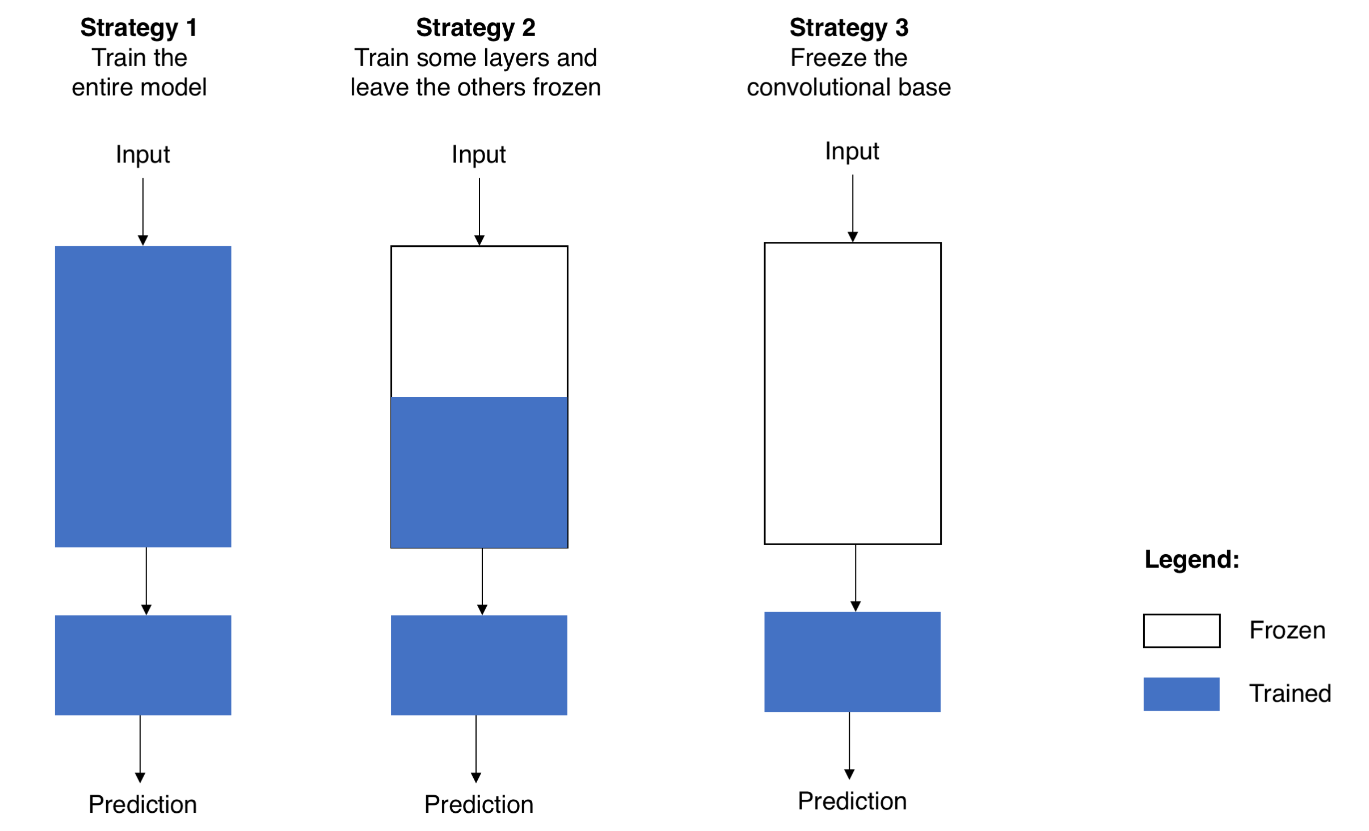

In [1]:
from IPython.display import Image
Image("strategies.png")

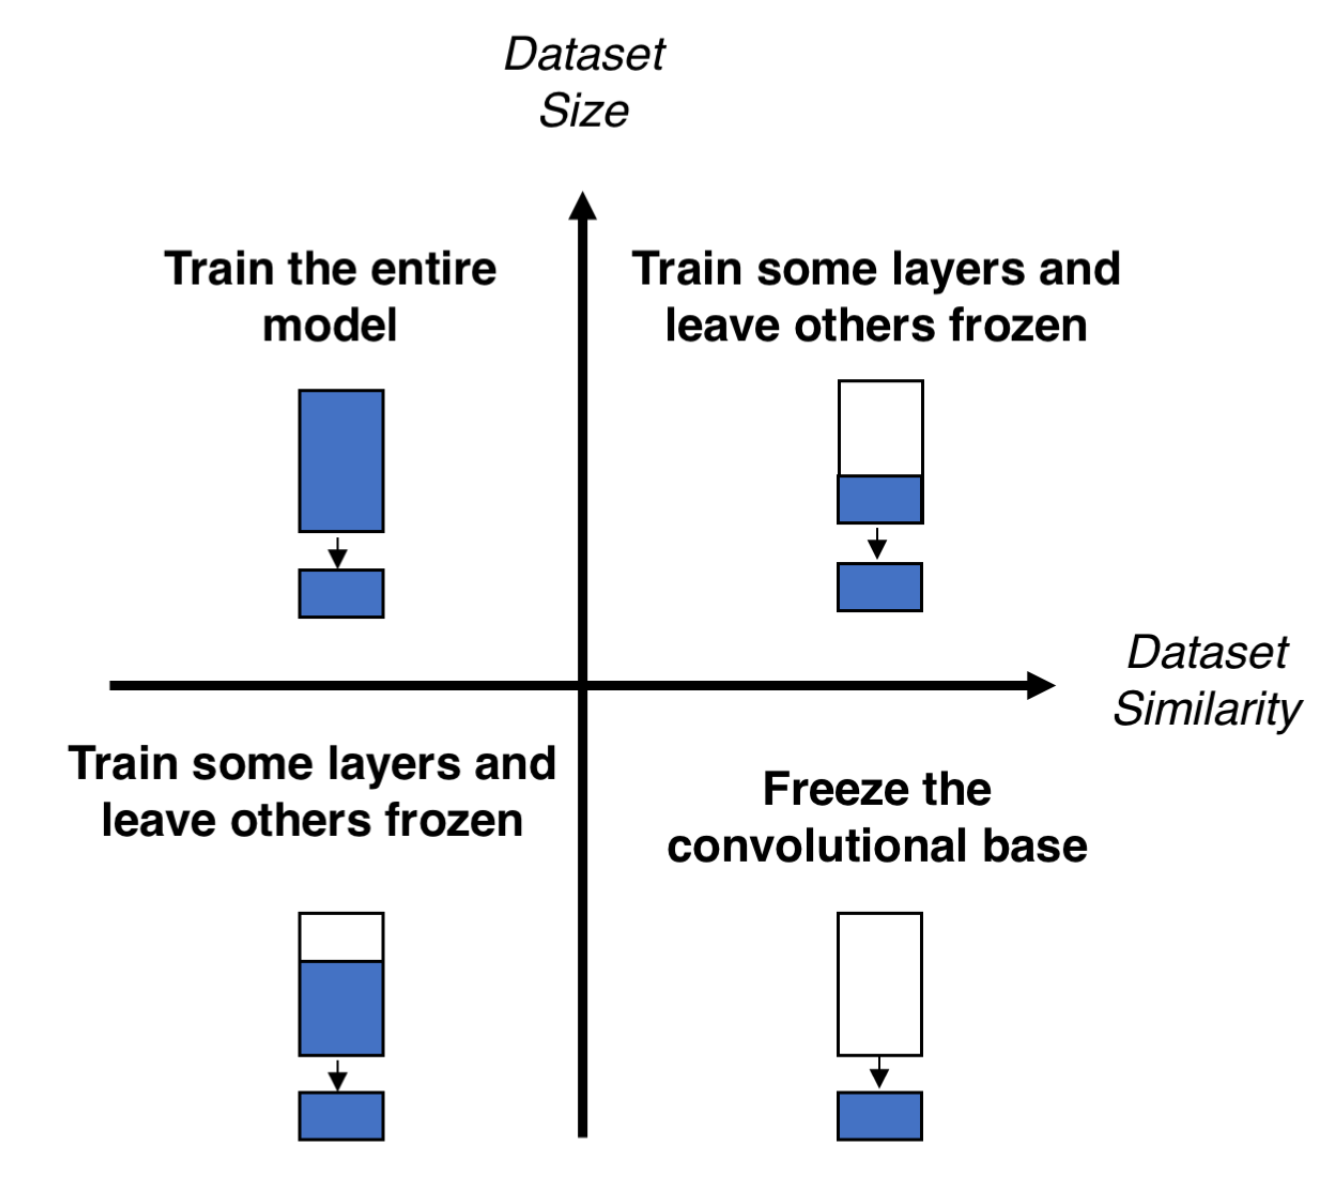

In [2]:
from IPython.display import Image
Image("approaches.png")

It is necessary to freeze the convolution base of the pre-trained network in order to be able to train a randomly initialized classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on top has already be trained, then the error signal propagating through the network during training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps for fine-tuning a network are as follow:

**Step1** Add your custom network on top of an already trained base network.

**Step2** Freeze the base network.

**Step3** Train the part you added (Classifier).

**Step4** Unfreeze some layers in the base network.

**Step5** Jointly train both these layers and the part you added.

# The Convolutional Base (conv_base)

In [3]:
img_width, img_height, img_channels = 128, 128, 3  # Default input size for VGG19 is 224,224

In [4]:
# Instantiate convolutional base
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', 
                  include_top=False, #false means that we want to train our own classifier on top of the convolutional base.
                  input_shape=(img_width, img_height, img_channels))  # 3 = number of channels in RGB pictures

Using TensorFlow backend.


In [5]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [6]:
conv_base.input_shape

(None, 128, 128, 3)

# Data preparation - Data augmentation

In [7]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = "../data/TTG_TUR/"
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
train_SIM_dir = os.path.join(train_dir, 'SIM')
train_NAO_dir = os.path.join(train_dir, 'NAO')
validation_SIM_dir = os.path.join(validation_dir, 'SIM')
validation_NAO_dir = os.path.join(validation_dir, 'NAO')
test_SIM_dir = os.path.join(test_dir, 'SIM')
test_NAO_dir = os.path.join(test_dir, 'NAO')


train_datagen = ImageDataGenerator(
      rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All imgs will be resized to img_height x img_width
        target_size=(img_height, img_width),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=20,
        class_mode='binary')

Found 5061 images belonging to 2 classes.
Found 632 images belonging to 2 classes.
Found 632 images belonging to 2 classes.


# Fully Connected Layers (FCL) classifier

## Modeling

This classifier adds a stack of fully-connected layers that is fed by the features extracted from the convolutional base.

In [8]:
# Define model

from keras import models
from keras import layers


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


In [9]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 36


In [10]:
conv_base.trainable = False

In [11]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [12]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 vgg19 False
1 flatten_1 True
2 dense_1 True
3 dropout_1 True
4 dense_2 True


With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 

If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with data augmentation.

## Compile model

In [13]:
import pandas as pd

def info_layers(conv_base,model):
    
    list_layer_name = []
    list_trainable = []

    for layer in conv_base.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    

    df1 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    list_layer_name = []
    list_trainable = []

    for layer in model.layers:
        list_layer_name.append(layer.name)
        list_trainable.append(layer.trainable)
    
    df2 = pd.DataFrame({'layer_name':list_layer_name, 'list_trainable':list_trainable})

    df2 = df2[1:]

    df= pd.concat([df1,df2])
    df.reset_index(drop=True,inplace=True)
    
    pd.options.display.max_rows = len(df)
    
    return df

In [14]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


We will fine-tune the last 4 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2`, `block5_conv3` and `block5_conv4` should be trainable.

In [15]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,block1_conv1,True
2,block1_conv2,True
3,block1_pool,True
4,block2_conv1,True
5,block2_conv2,True
6,block2_pool,True
7,block3_conv1,True
8,block3_conv2,True
9,block3_conv3,True


In [16]:
conv_base.trainable = True

for layer in conv_base.layers[:17]:
    layer.trainable = False

In [17]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_1,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


In [18]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [19]:
import datetime

# print(datetime.datetime.now())
t1 = datetime.datetime.now()
print(t1)

2019-11-27 14:45:27.377085


In [20]:
# Train model

# Using EarlyStopping

# Import EarlyStopping
from keras.callbacks import EarlyStopping

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=3)


history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 711s 7s/step - loss: 0.5791 - acc: 0.7415 - val_loss: 0.6561 - val_acc: 0.7601
Epoch 2/30
100/100 [==============================] - 730s 7s/step - loss: 0.5298 - acc: 0.7635 - val_loss: 0.4109 - val_acc: 0.7825
Epoch 3/30
100/100 [==============================] - 744s 7s/step - loss: 0.5039 - acc: 0.7780 - val_loss: 0.4050 - val_acc: 0.7954
Epoch 4/30
100/100 [==============================] - 722s 7s/step - loss: 0.5223 - acc: 0.7870 - val_loss: 0.4134 - val_acc: 0.7917
Epoch 5/30
100/100 [==============================] - 571s 6s/step - loss: 0.5035 - acc: 0.7770 - val_loss: 0.5528 - val_acc: 0.7833
Epoch 6/30
100/100 [==============================] - 571s 6s/step - loss: 0.4746 - acc: 0.8000 - val_loss: 0.5269 - val_acc: 0.7927


## Save model

In [21]:
model.save("../models/VGG19_firebreak_detection_fine_tuning_FC_model.h5")

## Model evaluation

### Learning curves

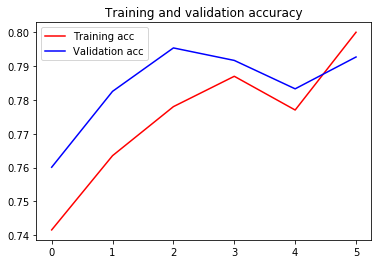

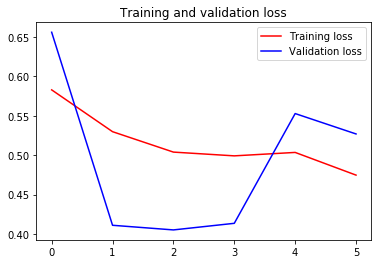

In [29]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/VGG19_firebreak_detection_fine_tuning_FC_history.csv", index = False)

In [24]:
t2 = datetime.datetime.now()
print(t2)
print(t2-t1)

2019-11-27 15:52:59.500459
1:07:32.123374


### Model in action

In [25]:
def prediction_dataframe(generator):
    """ Generate dataframe with filename, probability, and class of the image
    """
    

    # Predict from generator (returns probabilities)
    pred=model.predict_generator(generator, steps=len(generator), verbose=1)

    # Get classes by np.round
    cl = np.round(pred)
    # Get filenames (set shuffle=false in generator is important)
    filenames=generator.filenames

    # Data frame
    results=pd.DataFrame({"file_name":filenames,"prob":pred[:,0], "class":cl[:,0]})
    results['file_name'] = results['file_name'].apply(lambda x: x.split('\\')[-1])
    
    return results

In [26]:
# obtaining predictions for test images

results = prediction_dataframe(test_generator)
results.head()

32/32 [==============================] - 99s 3s/step


,file_name,prob,class
0,2017-12-12 11-56-38_NAO.jpeg,0.106630,0.0
1,2018-01-09 16-17-15_NAO.jpeg,0.173028,0.0
2,2018-01-09 17-10-54_NAO.jpeg,0.053935,0.0
3,2018-01-30 08-53-00_NAO.jpeg,0.334614,0.0
4,2018-01-30 09-07-13_NAO.jpeg,0.044406,0.0


In [27]:
# Define function to visualize predictions
import random
from keras.preprocessing import image

def visualize_predictions(classifier, n_cases, results):
    """ shows images and prediction considering threshold of 0.5 and test images"""
    
    for i in range(0,n_cases):
        path = random.choice([test_NAO_dir, test_SIM_dir])

        # Get picture
        random_img = random.choice(os.listdir(path))
        img_path = os.path.join(path, random_img)
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_tensor = image.img_to_array(img)  # Image data encoded as integers in the 0–255 range
        img_tensor /= 255.  # Normalize to [0,1] for plt.imshow application

        # Make prediction
        
        idx = results.index[results['file_name'] == random_img].tolist()
        prediction = results['prob'].loc[idx[0]]

        # Show picture
        plt.imshow(img_tensor)
        plt.show()

        # Write prediction
        if prediction < 0.5:
            print(random_img)
            print('Not firebreack')
        else:
            print(random_img)
            print('Firebreak')

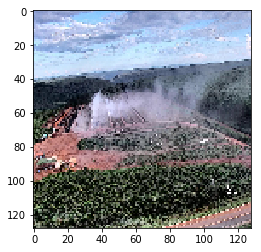

2018-03-13 17-05-35_SIM.jpeg
Not firebreack


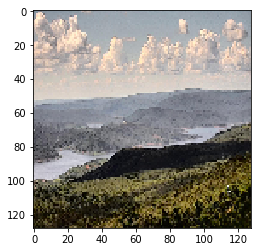

2018-03-17 14-48-44_SIM.jpeg
Not firebreack


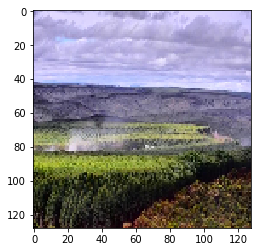

2019-07-22 09-46-32_SIM.jpeg
Not firebreack


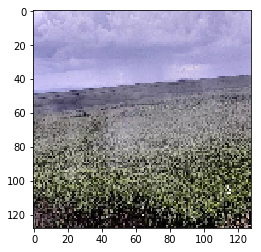

2018-03-17 14-29-34_SIM.jpeg
Not firebreack


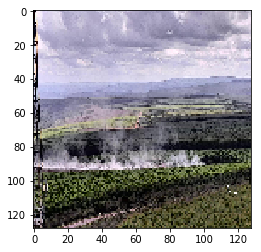

2018-03-17 10-57-00_SIM.jpeg
Not firebreack


In [28]:
# Visualize predictions
visualize_predictions(model, 5, results)

# Global average pooling

In [55]:
conv_base.input_shape

(None, 128, 128, 3)

In [54]:
# Instantiate convolutional base
from keras.applications import VGG19

conv_base = VGG19(weights='imagenet', 
                  include_top=False, #false means that we want to train our own classifier on top of the convolutional base.
                  input_shape=(img_width, img_height, img_channels))  # 3 = number of channels in RGB pictures

conv_base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

## Modeling

Instead of adding a stack of fully-connected layers, as before, we will add a global average pooling layer and fed its output into a sigmoid activated layer.

Note that we are talking about a sigmoid activated layers instead of a softmax one, which is what is recommended by [Lin et al. (2013)](https://arxiv.org/pdf/1312.4400.pdf). We are changing to the sigmoid activation because in Keras, to perform binary classification, you should use sigmoid activation and binary_crossentropy as the loss (see Chollet's book). Accordingly, it was necessary to do this small modification to the original proposal of Lin et al. (2013).

In [56]:
# Define model

from keras import models
from keras import layers

#Define model

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D(input_shape=(conv_base.output_shape[1], conv_base.output_shape[2], conv_base.output_shape[3])))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 20,024,897
Non-trainable params: 0
_________________________________________________________________


In [57]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 34


In [40]:
conv_base.trainable = False

In [41]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 2


In [42]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 vgg19
1 global_average_pooling2d_2
2 dense_4


## Compile model

In [43]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

0 input_2 False
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


We will fine-tune the last 4 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2`, `block5_conv3` and `block5_conv4` should be trainable.

In [44]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,block1_conv1,True
2,block1_conv2,True
3,block1_pool,True
4,block2_conv1,True
5,block2_conv2,True
6,block2_pool,True
7,block3_conv1,True
8,block3_conv2,True
9,block3_conv3,True


In [45]:
conv_base.trainable = True

for layer in conv_base.layers[:17]:
    layer.trainable = False

In [46]:
info_layers(conv_base,model)

,layer_name,list_trainable
0,input_2,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


In [47]:
# Compile model
from keras import optimizers

model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

## Train Model

In [48]:
# Train model

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
    callbacks=[early_stopping_monitor])

Epoch 1/30
100/100 [==============================] - 561s 6s/step - loss: 0.5115 - acc: 0.7764 - val_loss: 0.3328 - val_acc: 0.7681
Epoch 2/30
100/100 [==============================] - 573s 6s/step - loss: 0.5092 - acc: 0.7770 - val_loss: 0.6772 - val_acc: 0.7886
Epoch 3/30
100/100 [==============================] - 569s 6s/step - loss: 0.4747 - acc: 0.7920 - val_loss: 0.6882 - val_acc: 0.7984
Epoch 4/30
100/100 [==============================] - 602s 6s/step - loss: 0.4797 - acc: 0.7910 - val_loss: 0.5569 - val_acc: 0.7774


## Save model

In [49]:
model.save("../models/VGG19_firebreak_detection_fine_tuning_GAP_model.h5")

# Model evaluation

## Learning curves

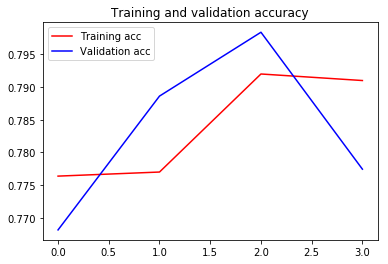

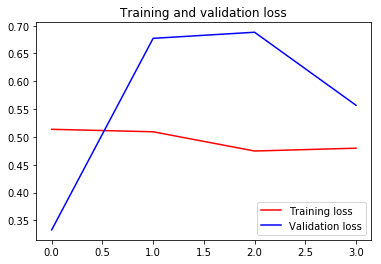

In [50]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [51]:
# create a dataframe to save the result as .csv
import pandas as pd

df = pd.DataFrame(history.history)

df.to_csv("../models/VGG19_firebreak_detection_fine_tuning_GAP_history.csv", index = False)

In [52]:
t3 = datetime.datetime.now()
print(t3)
print(t3-t2)

2019-11-27 17:46:01.011397
1:53:01.510938


## Model in action

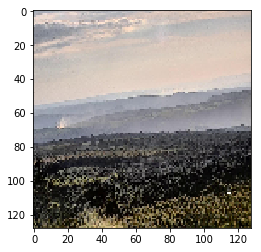

2018-03-04 07-10-07_SIM.jpeg
Not firebreack


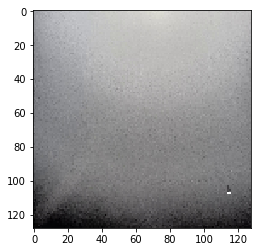

2018-03-14 07-08-46_NAO.jpeg
Not firebreack


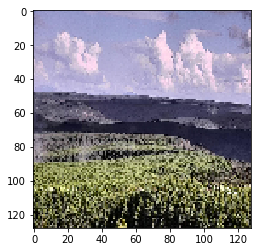

2018-03-18 16-00-24_NAO.jpeg
Not firebreack


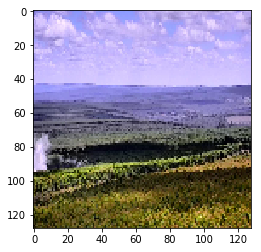

2019-01-31 11-29-23_SIM.jpeg
Not firebreack


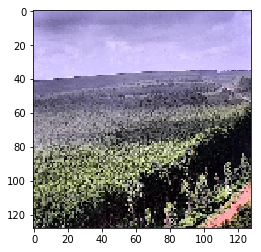

2018-03-16 08-57-32_NAO.jpeg
Not firebreack


In [53]:
# Visualize predictions
visualize_predictions(model, 5, results)

**REFERENCES**

https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751

https://github.com/fchollet/deep-learning-with-python-notebooks